# Cluster

Taking our clean df from 1_wrangle, checking assumptions, figuring out how many clusters to extract, and clustering on dietary patterns.


## Housekeeping

In [ ]:
# If in colab, mount drive and set wd
# If local, set wd to parent of notebook
import os
import re

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ds1_nhanes/')
except:
  from pathlib import Path
  if not re.search(r'ds1_nhanes$', str(os.getcwd())):
    os.chdir(Path(os.getcwd()).parent)

print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1-4PHX9XhMUWpi_lTsGHtTyz6s3O0u5a2/ds1_nhanes


## K means clustering using sklearn

### Import necessary libraries and wrangled dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read in the cleaned dietary recall data matched with FPED
nhanes = pd.read_csv('data/clean/nhanes_2017_2023_clean.csv', usecols = [0] + list(range(3, 40)))

# break out the identifier and features
id = nhanes.iloc[:,0]
foodgroups = nhanes.iloc[:,1:]

nhanes.head()

,SEQN,f_total_(cup_eq),f_citmlb_(cup_eq),f_other_(cup_eq),f_juice_(cup_eq),v_total_(cup_eq),v_drkgr_(cup_eq),v_redor_total_(cup_eq),v_redor_tomato_(cup_eq),v_redor_other_(cup_eq),...,pf_nutsds_(oz_eq),pf_legumes_(oz_eq),d_total_(cup_eq),d_milk_(cup_eq),d_yogurt_(cup_eq),d_cheese_(cup_eq),oils_(grams),solid_fats_(grams),add_sugars_(tsp_eq),a_drinks_(no._of_drinks)
0,109263,1.60,0.00,0.00,1.60,0.36,0.00,0.15,0.15,0.00,...,1.99,0.00,3.47,0.26,0.00,3.19,25.41,82.28,49.04,0.0
1,109264,0.00,0.00,0.00,0.00,4.17,0.86,1.03,0.66,0.37,...,0.52,0.00,3.26,0.12,0.00,3.09,119.77,107.89,43.70,0.0
2,109265,2.28,0.67,0.41,1.20,3.34,0.21,0.38,0.16,0.22,...,0.00,0.00,3.82,1.43,0.00,2.35,104.86,168.54,45.45,0.0
3,109266,0.87,0.70,0.17,0.00,3.98,0.07,0.60,0.16,0.44,...,0.44,0.46,5.40,0.20,0.26,2.44,82.41,40.39,14.80,0.0
4,109269,0.04,0.00,0.00,0.04,1.85,0.00,0.10,0.10,0.00,...,0.00,0.00,3.31,0.25,0.00,2.99,175.65,87.97,18.82,0.0


### Standardize using standard scalar

[When working with distance-based algorithms, like k-Means Clustering, we must normalize the data. If we do not normalize the data, variables with different scaling will be weighted differently in the distance formula that is being optimized during training. The different FPED categories have different units, cup vs. oz, and each food may have a different range of total weight consumed.

StandardScaler is commonly used for standardization:]

In [ ]:
# import sci-kit for standardscaler
from sklearn.preprocessing import StandardScaler

# initialize the StandardScaler
scaler = StandardScaler()

# apply StandardScaler to the
foodgroups_scaled = scaler.fit_transform(foodgroups)

### Apply k means clustering

In [ ]:
# import sci-kit for k means clustering
from sklearn.cluster import KMeans

# apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(foodgroups_scaled)

# reconstruct the DataFrame with the identifier and cluster labels
nhanes_clustered = pd.DataFrame(nhanes.iloc[:, 0])  # Keep the identifier
nhanes_clustered['Cluster'] = clusters

# display the first few rows
print(nhanes_clustered.head())

### Determine optimal number of clusters

[We do not know how many clusters we should be using, the Silhoette Score and Elbow Method is commonly used to find the optimal number of clusters to ensure we are not overfitting with too many clusters or underfitting with too few.

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

The elbow method measures how tightly points cluster around centroids using sum of squared distances (SSD), the elbow is where the SSD stops decreasing sharply.]

In [25]:
from sklearn.metrics import silhouette_score
from matplotlib.ticker import FuncFormatter

K = range(2, 12)
fits = []
elbow_score = []
silhouette_scores = []

for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(foodgroups_scaled)

    # append the model to fits
    fits.append(model)

    # Append the silhouette score to scores
    silhouette_scores.append(silhouette_score(foodgroups_scaled, model.labels_, metric='euclidean'))

    # Store inertia (sum of squared distances)
    elbow_score.append(model.inertia_)

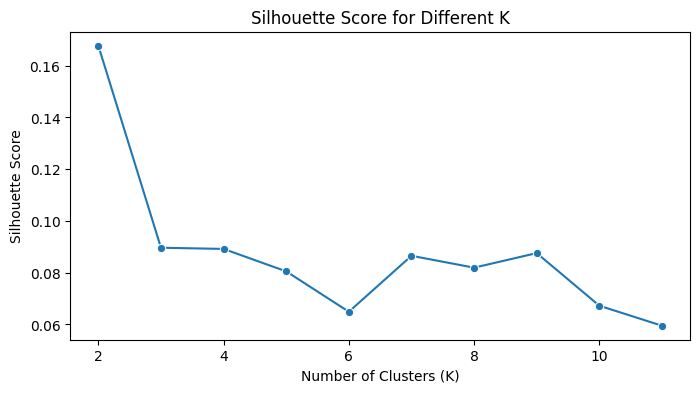

In [26]:
# plot Silhouette Score
plt.figure(figsize=(8, 4))
sns.lineplot(x=K, y=silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.show()

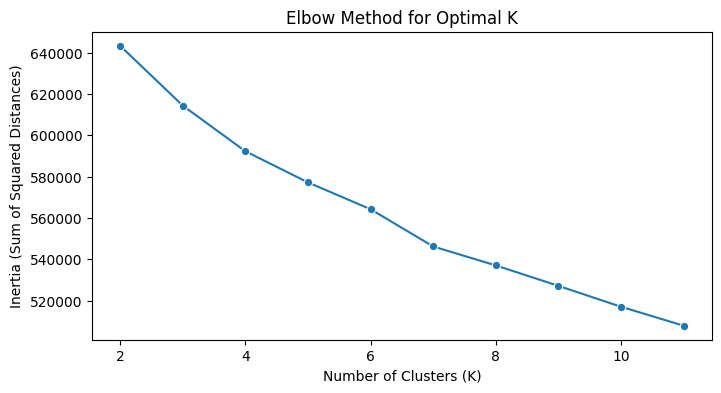

In [27]:
# plot Elbow Method
plt.figure(figsize=(8, 4))
sns.lineplot(x=K, y=elbow_score, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.show()